### (colab setting)

In [1]:
# 필요 라이브러리 호출
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
#colab plot의 한글깨짐 해결

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.



## **주제**
비디오 게임 데이터를 이용하여 출시할 게임 설계하기 

## **목표(Goal of Project)**
1.   어떤 장르의 게임을 출시할 것 인가?
2.   어떤 플렛폼을 통하여 출시할 것인가?
3.   어느 지역에 출시할 것인가?
4.   어느 게임회사를 통해서 출시할 것인가?
5.   언제 출시하는 것이 가장 좋은가?

## **항목(Contents)**
1. 데이터 개요
2. EDA & 전처리(pre-processing)
3. feature engineering
4. 분석 및 결과
  * 지역별로 선호하는 게임장르가 있을까?
  * 게임시장의 연도별 트랜드(장르, 플랫폼)는 어떠한가?
  * 인기있는 게임은 어떤 특징들이 있는가?
  * 닌텐도에서 새롭게 게임 출시를 한다면 어떨까?
5. 결론
---




## 1. 데이터 개요


 **데이터 설명(Data Description)**

Name : 게임의 이름입니다.  
Platform : 게임이 지원되는 플랫폼의 이름입니다.  
Year : 게임이 출시된 연도입니다.  
Genre : 게임의 장르입니다.  
Publisher : 게임을 제작한 회사입니다.  
NA_Sales : 북미지역에서의 출고량입니다.  
EU_Sales : 유럽지역에서의 출고량입니다.  
JP_Sales : 일본지역에서의 출고량입니다.  
Other_Sales : 기타지역에서의 출고량입니다.  


In [4]:
# 데이터 불러오기
df = pd.read_csv('/content/vgames2.csv').rename(columns = {'Unnamed: 0':'index'}).set_index('index')
df.head(20)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
index,,,,,,,,,
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
6,Power Pro Kun Pocket 8,DS,2005.0,Sports,Konami Digital Entertainment,0,0,0.14,0
7,JASF: Jane's Advanced Strike Fighters,PC,2011.0,Simulation,Deep Silver,0.02,0.01,0,0
8,Samurai Warriors: State of War,PSP,2005.0,Action,Tecmo Koei,0.07,0,0.11,0.01
9,Imabikisou,PS3,2007.0,Adventure,Sega,0,0,0.04,0


## 2. EDA & 데이터 전처리(Data Pre-processing)


In [5]:
print('  데이터 개수, 데이터 타입, 결측값 확인')
print(df.info())
print('\n 평균,최대,최소값 확인\n',df.describe())

  데이터 개수, 데이터 타입, 결측값 확인
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB
None

 평균,최대,최소값 확인
                Year
count  16327.000000
mean    1994.242543
std      155.077168
min        0.000000
25%     2003.000000
50%     2007.000000
75%     2010.000000
max     2020.000000



1. 총 9개의 열(columns)과 16598개의 행(rows)으로 이루어진 데이터셋임을 알 수 있다.  
    **=> shape(16598,9)**  
2. 지역별 출고량의 데이터 타입이 object이다.   
    **=> 숫자형 타입으로 바꾸어 분석에 용이하도록 전처리**
3. 장르(Genre), 연도(Year), 제작회사(Publisher)에 각각 결측값들이 있다.   
    **=> 결측 값 처리**
4. 평균,분산 최대최소값을 보려 하였으나 타입 변경이 필요함.

In [6]:
# 출고량 데이터 숫자단위 통일시키고 숫자타입으로 타입 변경하기
def unit(x):
  if str(x).find("K") != -1:
    return float(str(x).split("K")[0].replace('.',''))*1000
  elif str(x).find("M") != -1:
    return float(str(x).split("M")[0].replace('.',''))*1000000
  else:
    return float(str(x).replace('.',''))*1000000

for col in ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']:
  df[col] = df[col].apply(unit)
print(df.dtypes)
df.head()

Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales       float64
EU_Sales       float64
JP_Sales       float64
Other_Sales    float64
dtype: object


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
index,,,,,,,,,
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,4000000.0,0.0,0.0,0.0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,17000000.0,0.0,0.0,1000000.0
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,2000000.0,0.0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,4000000.0,0.0,0.0,0.0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,12000000.0,9000000.0,0.0,4000000.0


In [7]:
# 결측값 처리
df.dropna(inplace=True)
print('결측값 처리\n\n',df.isnull().sum())

결측값 처리

 Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64


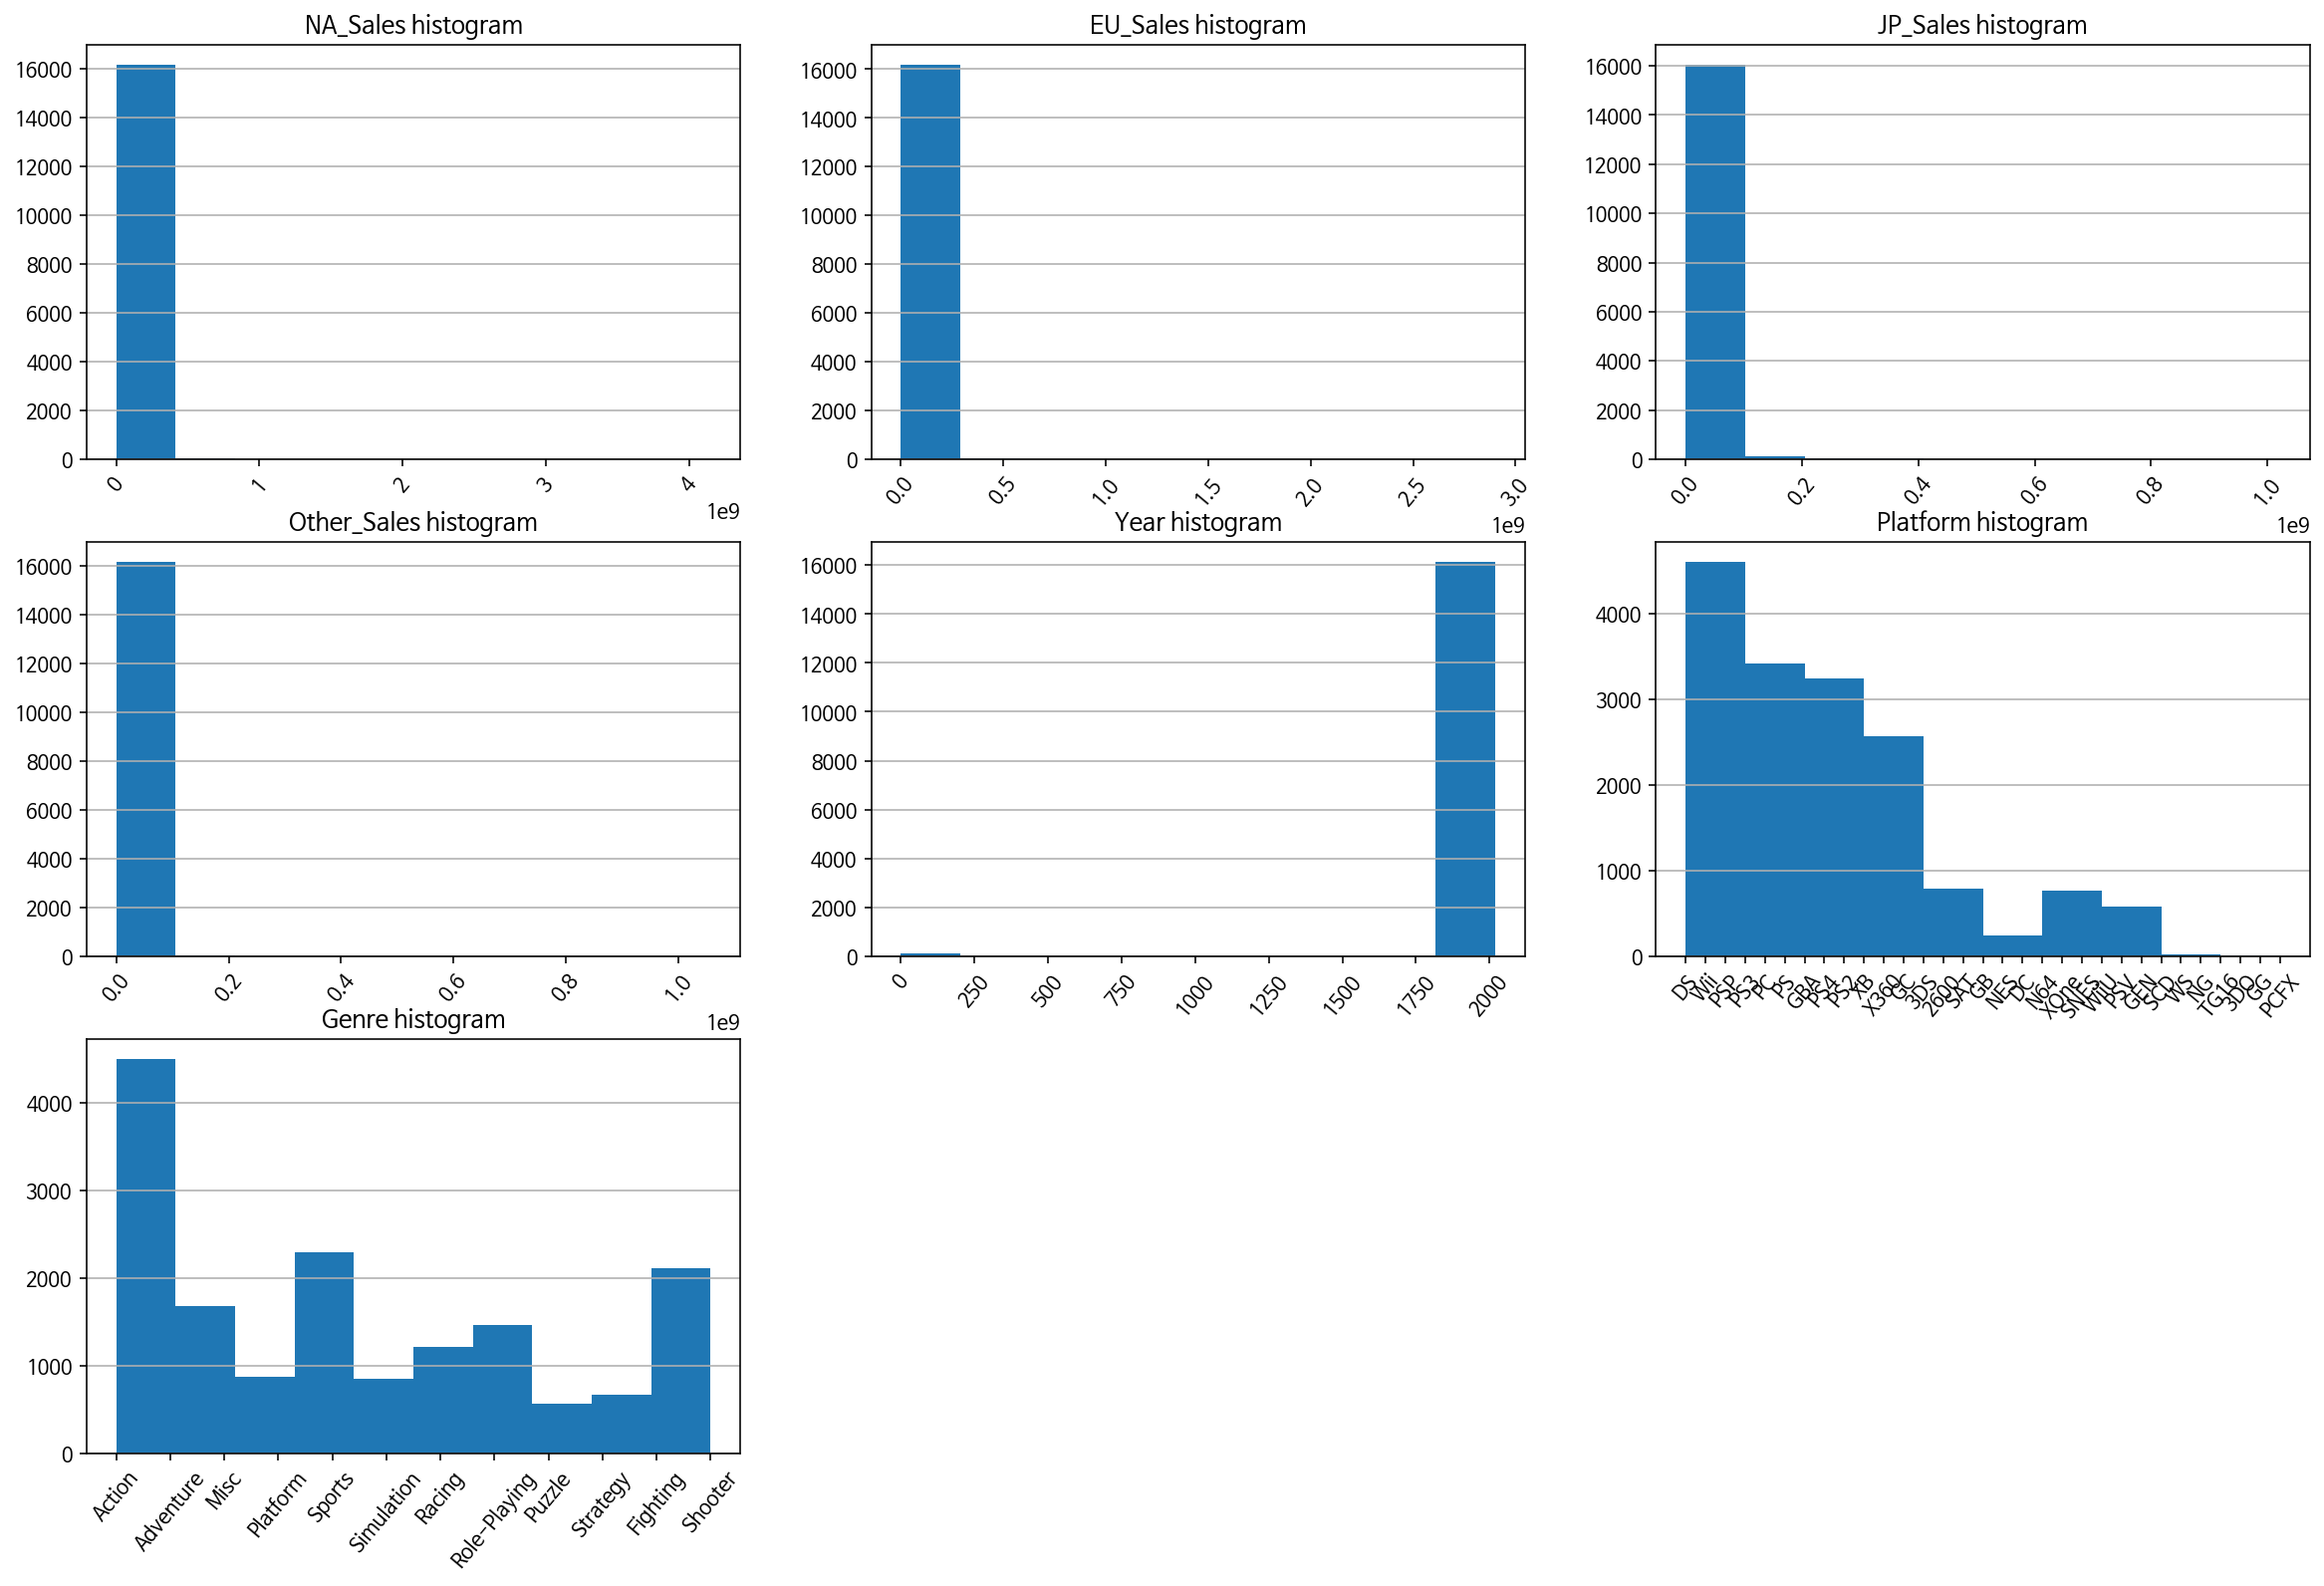

In [8]:
# 칼럼별 분포 확인

plt.figure(figsize=(20,13))

for i,col_name in enumerate(df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Year','Platform','Genre']]):
  plt.subplot(3,3,i+1)
  plt.hist(df[col_name])
  plt.title(str(col_name)+' histogram')
  plt.grid(True,axis='y')
  plt.xticks(rotation=50)
plt.show()


*  자세히보면 '연도그래프(Year histogram)'에서 에서 0~250 사이에도 데이터가 분포하고 있음을 볼 수 있다. 
*  비디오게임의 최초 출시 시기를 고려했을 때, 연도데이터에서 앞의 두자리를 생략하여 입력하였음을 짐작할 수 있다.
* **연도데이터 조정이 필요해보인다.**


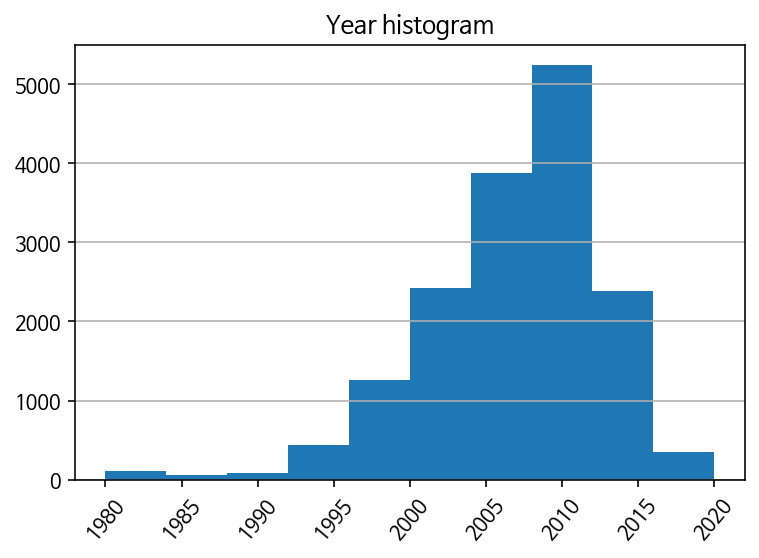


연도
 [1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991.
 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003.
 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.
 2016. 2017. 2020.]


In [9]:
# 연도 데이터 조정
def year_adj(x):
  if x <= 20:
    return x + 2000
  elif x <= 100:
    return x + 1900
  else:
    return x

df['Year'] = df['Year'].apply(year_adj) # 함수 적용

plt.hist(df['Year'])
plt.title('Year histogram')
plt.grid(True,axis='y')
plt.xticks(rotation=50)
plt.show()

print('\n연도\n',np.sort(df['Year'].unique()))

# 연도 데이터가 형식에 맞게 조정된것을 볼 수 있다.

## 3. Feature Engineering

In [10]:
# 전체 출고량(Global_Sales) Feature 만들기
df['Global_Sales'] = df['NA_Sales']+df['EU_Sales']+df['JP_Sales']+df['Other_Sales']

# 연대를 알 수 있는 Feature 만들기
conditions = [df['Year'] <= 1985,
              (df['Year'] > 1985) & (df['Year'] <=1990),
              (df['Year'] > 1990) & (df['Year'] <=1995),
              (df['Year'] > 1995) & (df['Year'] <=2000), 
              (df['Year'] > 2000) & (df['Year'] <= 2005),
              (df['Year'] > 2005) & (df['Year'] <= 2010),
              (df['Year'] > 2010) & (df['Year'] <= 2015),
              (df['Year'] > 2015) & (df['Year'] <= 2020)
]

values = ['1980-1985','1985-1990','1990-1995','1995-2000','2000-2005','2005-2010','2010-2015','2015-2020']

df['Years'] = np.select(conditions,values)
df.head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Years
index,,,,,,,,,,,
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,4000000.0,0.0,0.0,0.0,4000000.0,2005-2010
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,17000000.0,0.0,0.0,1000000.0,18000000.0,2005-2010
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,2000000.0,0.0,2000000.0,2005-2010
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,4000000.0,0.0,0.0,0.0,4000000.0,2005-2010
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,12000000.0,9000000.0,0.0,4000000.0,25000000.0,2005-2010
6,Power Pro Kun Pocket 8,DS,2005.0,Sports,Konami Digital Entertainment,0.0,0.0,14000000.0,0.0,14000000.0,2000-2005
7,JASF: Jane's Advanced Strike Fighters,PC,2011.0,Simulation,Deep Silver,2000000.0,1000000.0,0.0,0.0,3000000.0,2010-2015
8,Samurai Warriors: State of War,PSP,2005.0,Action,Tecmo Koei,7000000.0,0.0,11000000.0,1000000.0,19000000.0,2000-2005
9,Imabikisou,PS3,2007.0,Adventure,Sega,0.0,0.0,4000000.0,0.0,4000000.0,2005-2010


##4. 분석 및 결과

1. 지역별로 선호하는 게임장르가 있을까?
2. 게임시장의 연도별 트랜드(장르, 플랫폼)는 어떠한가?
3. 인기있는 게임은 어떤 특징들이 있는가?
4. 닌텐도에서 새롭게 게임 출시를 한다면 어떨까?






### 1. 지역별로 선호하는 게임 장르가 있을까?

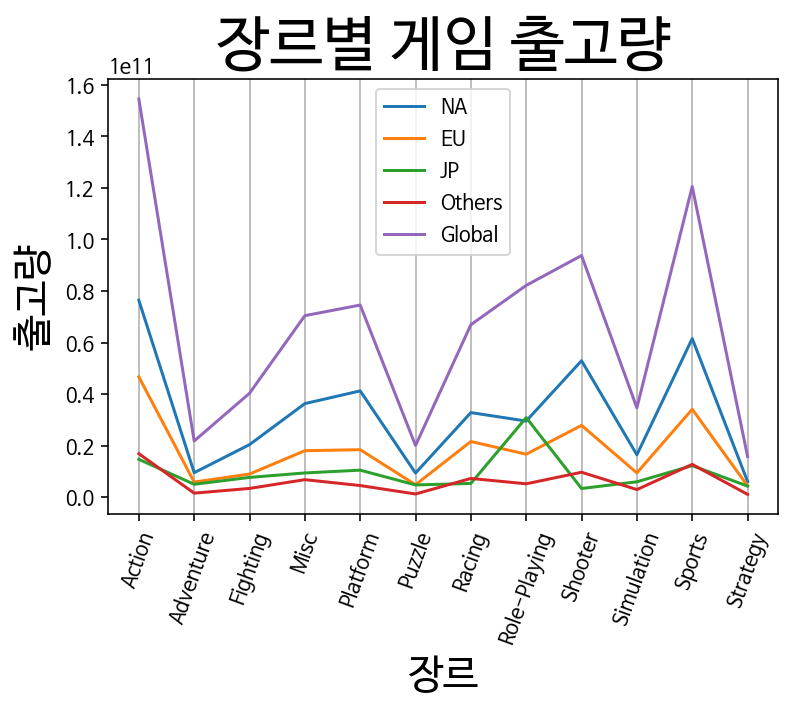

In [11]:
# 지역별 게임 출고량 분포 확인
group = df.groupby("Genre").sum()
plt.plot(group['NA_Sales'],label="NA")
plt.plot(group['EU_Sales'],label="EU")
plt.plot(group['JP_Sales'],label="JP")
plt.plot(group['Other_Sales'],label="Others")
plt.plot(group['Global_Sales'],label="Global")
plt.xlabel('장르',fontsize=20)
plt.ylabel('출고량',fontsize=20)
plt.xticks(rotation=70)
plt.grid(axis='x')
plt.title("장르별 게임 출고량",fontsize=30)
plt.legend()
plt.show()

그래프를 보았을 때 전체적으로 Action,Sports,Shooter,Role-Playing,Platform, 장르를 선호하는 것을 볼 수 있다.  
특별히 주목할만한 부분은 일본 지역에서 Role-Playing 장르가 인기있는 것을 시각적으로 확인할 수 있다.  
이것을 통계적으로 의미있는 차이인지 검증해보자 한다.   

**"일본(JP)에서 Role-playing 장르가 특별히 더 인기있는 장르인가?"**  
**"일본의 출고량 분포는 다른지역의 출고량 분포와 다른가?"**  
이 질문에 대해서 분석해보자.

In [12]:
group = df.groupby('Genre')
f_exp_G = [group['Global_Sales'].sum()[x]/(group['Global_Sales'].sum()).sum() for x in range(0,len(group))] # 전세계(Global)출고량중 장르별 출고량 비율
f_exp_NA = [group['NA_Sales'].sum()[x]/(group['NA_Sales'].sum()).sum() for x in range(0,len(group))] # 북미(NA)출고량중 장르별 출고량 비율
f_exp_EU = [group['EU_Sales'].sum()[x]/(group['EU_Sales'].sum()).sum() for x in range(0,len(group))] # 유럽(EU)출고량중 장르별 출고량 비율
f_exp_Other = [group['Other_Sales'].sum()[x]/(group['Other_Sales'].sum()).sum() for x in range(0,len(group))] # 기타지역(Other)출고량중 장르별 출고량 비율

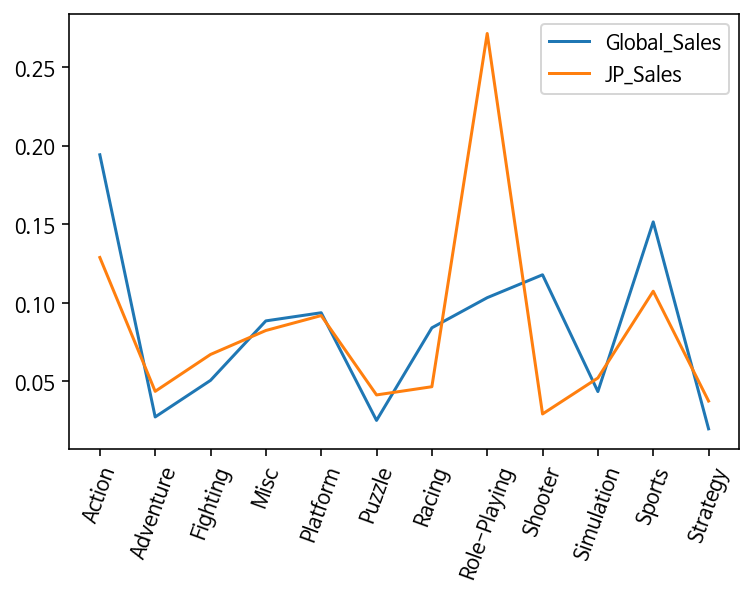

In [22]:
plt.plot(f_exp_G,label='Global_Sales')
plt.plot(f_obs_JP,label='JP_Sales')
plt.legend()
x = range(0,12)
labels = ['Action','Adventure','Fighting','Misc','Platform','Puzzle','Racing','Role-Playing','Shooter','Simulation','Sports','Strategy']
plt.xticks(x,labels,rotation = 70)
plt.show()

In [13]:
# 1 sample chi_square test

group = df.groupby('Genre')
f_obs_JP = [group['JP_Sales'].sum()[x]/(group['JP_Sales'].sum()).sum() for x in range(0,len(group))] # 일본지역(JP) 출고량 중 장르별 출고량 비중
print('statistic:',stats.chisquare(f_obs_JP,f_exp_G)[0])
print('p-value:',stats.chisquare(f_obs_JP,f_exp_G)[1])
print('''
=> 귀무가설(H0) : 전체출고량의 분포와 일본지역(JP) 출고량의 분포의 차이가 없다
   대립가설(H1) : 전체출고량의 분포와 일본지역(JP) 출고량의 분포의 차이가 있다.

=> p-value가 0.9999로 0.05보다 크므로 이므로 귀무가설을 기각하지 못한다.
   전체 전체출고량의 분포와 일본지역(JP)출고량의 분포에는 차이가 없다.
   즉, 일본지역(JP)에는 전세계적 장르분포와 비교하였을때 특별히 선호하는 게임장르가 없는것으로 볼 수 있다.''')

statistic: 0.43548492275496625
p-value: 0.9999993398652639

=> 귀무가설(H0) : 전체출고량의 분포와 일본지역(JP) 출고량의 분포의 차이가 없다
   대립가설(H1) : 전체출고량의 분포와 일본지역(JP) 출고량의 분포의 차이가 있다.

=> p-value가 0.9999로 0.05보다 크므로 이므로 귀무가설을 기각하지 못한다.
   전체 전체출고량의 분포와 일본지역(JP)출고량의 분포에는 차이가 없다.
   즉, 일본지역(JP)에는 전세계적 장르분포와 비교하였을때 특별히 선호하는 게임장르가 없는것으로 볼 수 있다.


In [ ]:
print(' [p-value]')
print("북미지역과 비교했을 때:",stats.chisquare(f_obs_JP,f_exp_NA)[1])
print("유럽지역과 비교했을 때:",stats.chisquare(f_obs_JP,f_exp_EU)[1])
print("기타지역과 비교했을 때:",stats.chisquare(f_obs_JP,f_exp_Other)[1])

 [p-value]
북미지역과 비교했을 때: 0.9999907641134606
유럽지역과 비교했을 때: 0.9999913861494459
기타지역과 비교했을 때: 0.9999741493569778


그래프로 보았을때는 일본(JP)지역에서 Role-Playing 장르에 선호를 보이는 것으로 나타났으나   
1-sample 카이제곱 검정을 시행한 결과 통계적으로 유의미한 차이를 보이진 않았다.  
**지역별로 선호하는 장르가 있다고 판단하기 어렵다.**

### 2. 게임시장의 연도별 트랜드(장르, 플랫폼)는 어떠한가?



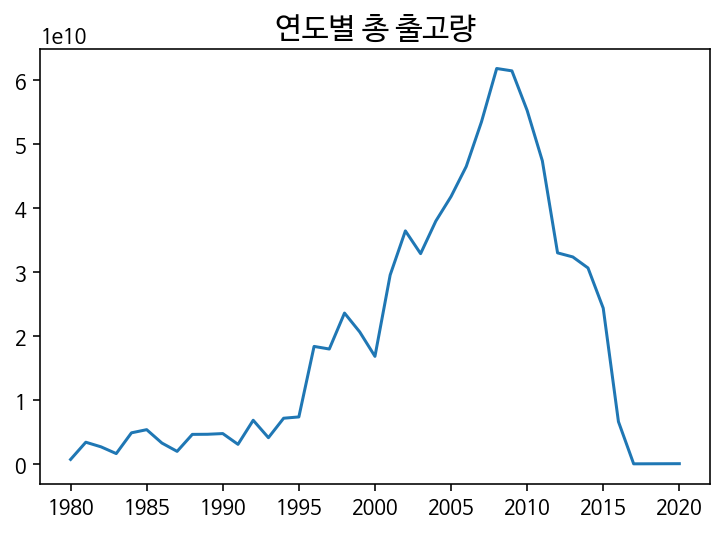

In [ ]:
# 연도별 총 출고량 시각화
plt.plot(df.groupby('Year')['Global_Sales'].sum())
plt.title(str("연도별 총 출고량"),fontsize=15)
plt.show()

1980년-1990년: **(시작)**비디오게임이 출시되기 시작하였고     
1990년-2000년: **(성장)**출고량이 증가하기 시작하면서 비디오게임 시장이 성장하기 시작한다.  
2000년-2010년: **(절정)**본격적인 성장세를 보여주고 있다.    
2010년-2020년: **(감소)**서서히 감소하는 추세를 보이고 있다.



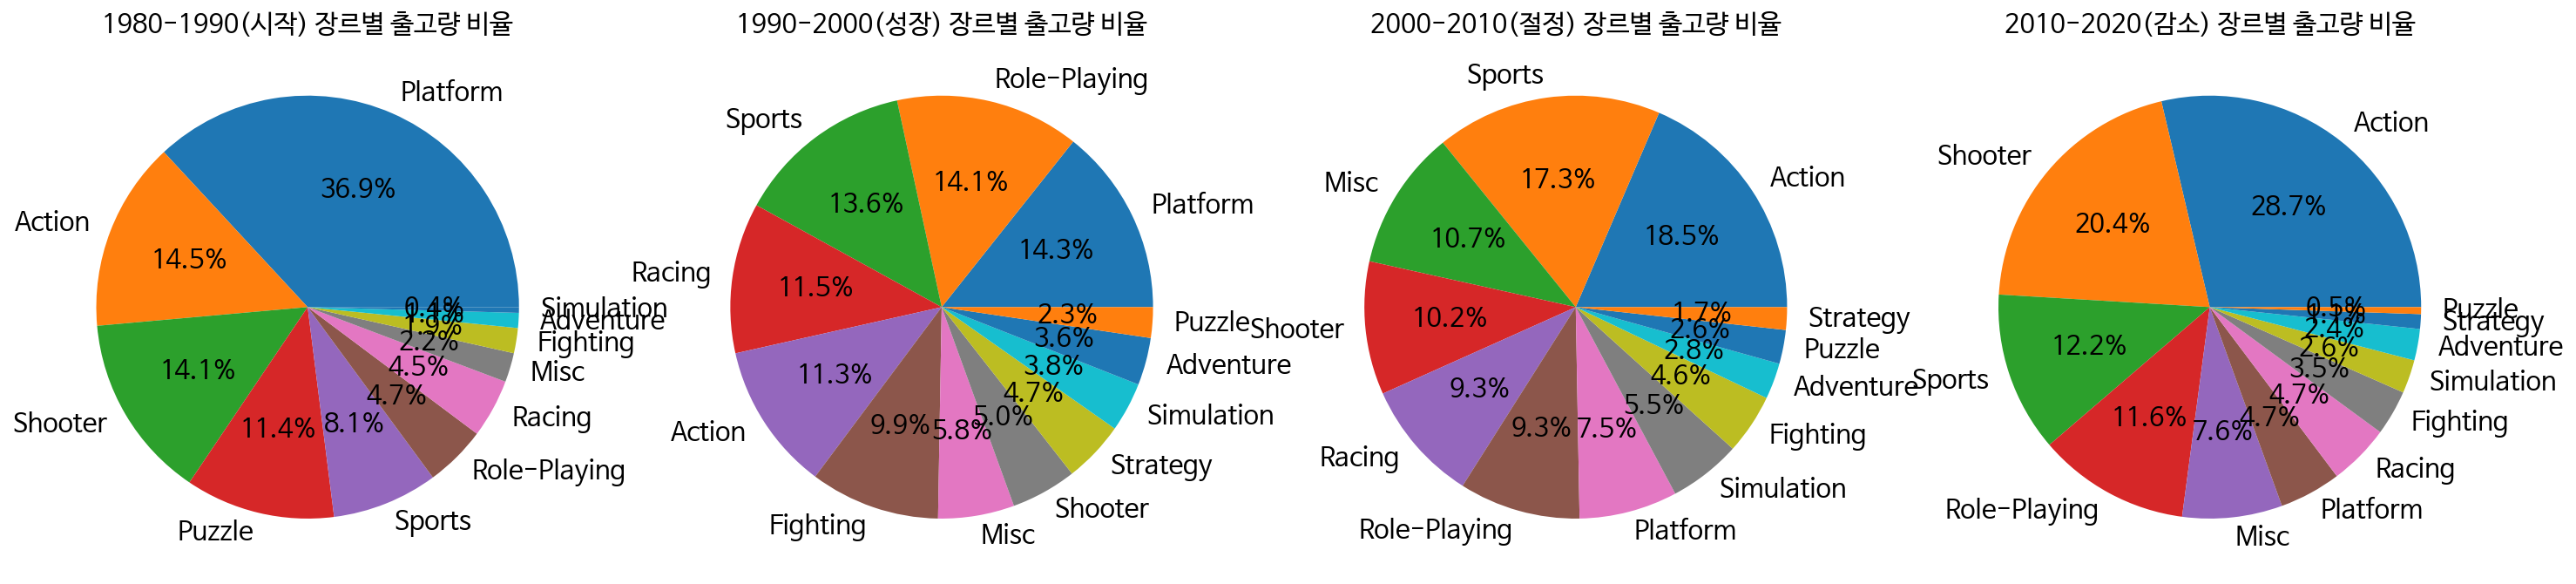

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (25,25))
# 1980-1990(시작) 장르별 출고량
ratio1980 = df[df['Year'] <= 1990].groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
labels1980 = ratio1980.index
ax[0].pie(ratio1980,labels =labels1980, autopct='%.1f%%',textprops={'fontsize': 15})
ax[0].set_title('1980-1990(시작) 장르별 출고량 비율',fontsize = 15)

# 1990-2000(성장) 장르별 출고량
ratio1990 = df[(df['Year'] > 1990)&(df['Year'] <= 2000)].groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
labels1990 = ratio1990.index
ax[1].pie(ratio1990,labels =labels1990, autopct='%.1f%%',textprops={'fontsize': 15})
ax[1].set_title('1990-2000(성장) 장르별 출고량 비율',fontsize = 15)

# 2000-2010(절정) 장르별 출고량 비율
ratio2000 = df[(df['Year'] > 2000)&(df['Year'] <= 2010)].groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
labels2000 = ratio2000.index
ax[2].pie(ratio2000,labels =labels2000, autopct='%.1f%%',textprops={'fontsize': 15})
ax[2].set_title('2000-2010(절정) 장르별 출고량 비율',fontsize = 15)

# 2010-2020(감소) 장르별 출고량 비율
ratio2010 = df[(df['Year'] > 2010)&(df['Year'] <= 2020)].groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
labels2010 = ratio2010.index
ax[3].pie(ratio2010,labels =labels2010, autopct='%.1f%%',textprops={'fontsize': 15})
ax[3].set_title('2010-2020(감소) 장르별 출고량 비율',fontsize = 15)

plt.show()

1980년-1990년: (시작) platform 장르가 강세를 보이고 있다.  
1990년-2000년: (성장) Platform 장르의 비율이 낮아졌지만 다양한 장르에서 골고루 소비되기 시작한다.  
2000년-2010년: (절정) Action, sports 장르가 인기를 얻기 시작한다.  
2010년-2020년: (감소) 가장 인기있는 3가지 장르는 순서대로 1.Action 2.Shooter 3.Sport이다.서서히 감소하는 추세를 보이고 있다.  
(연대별 1위는 파란색으로 나타난다)

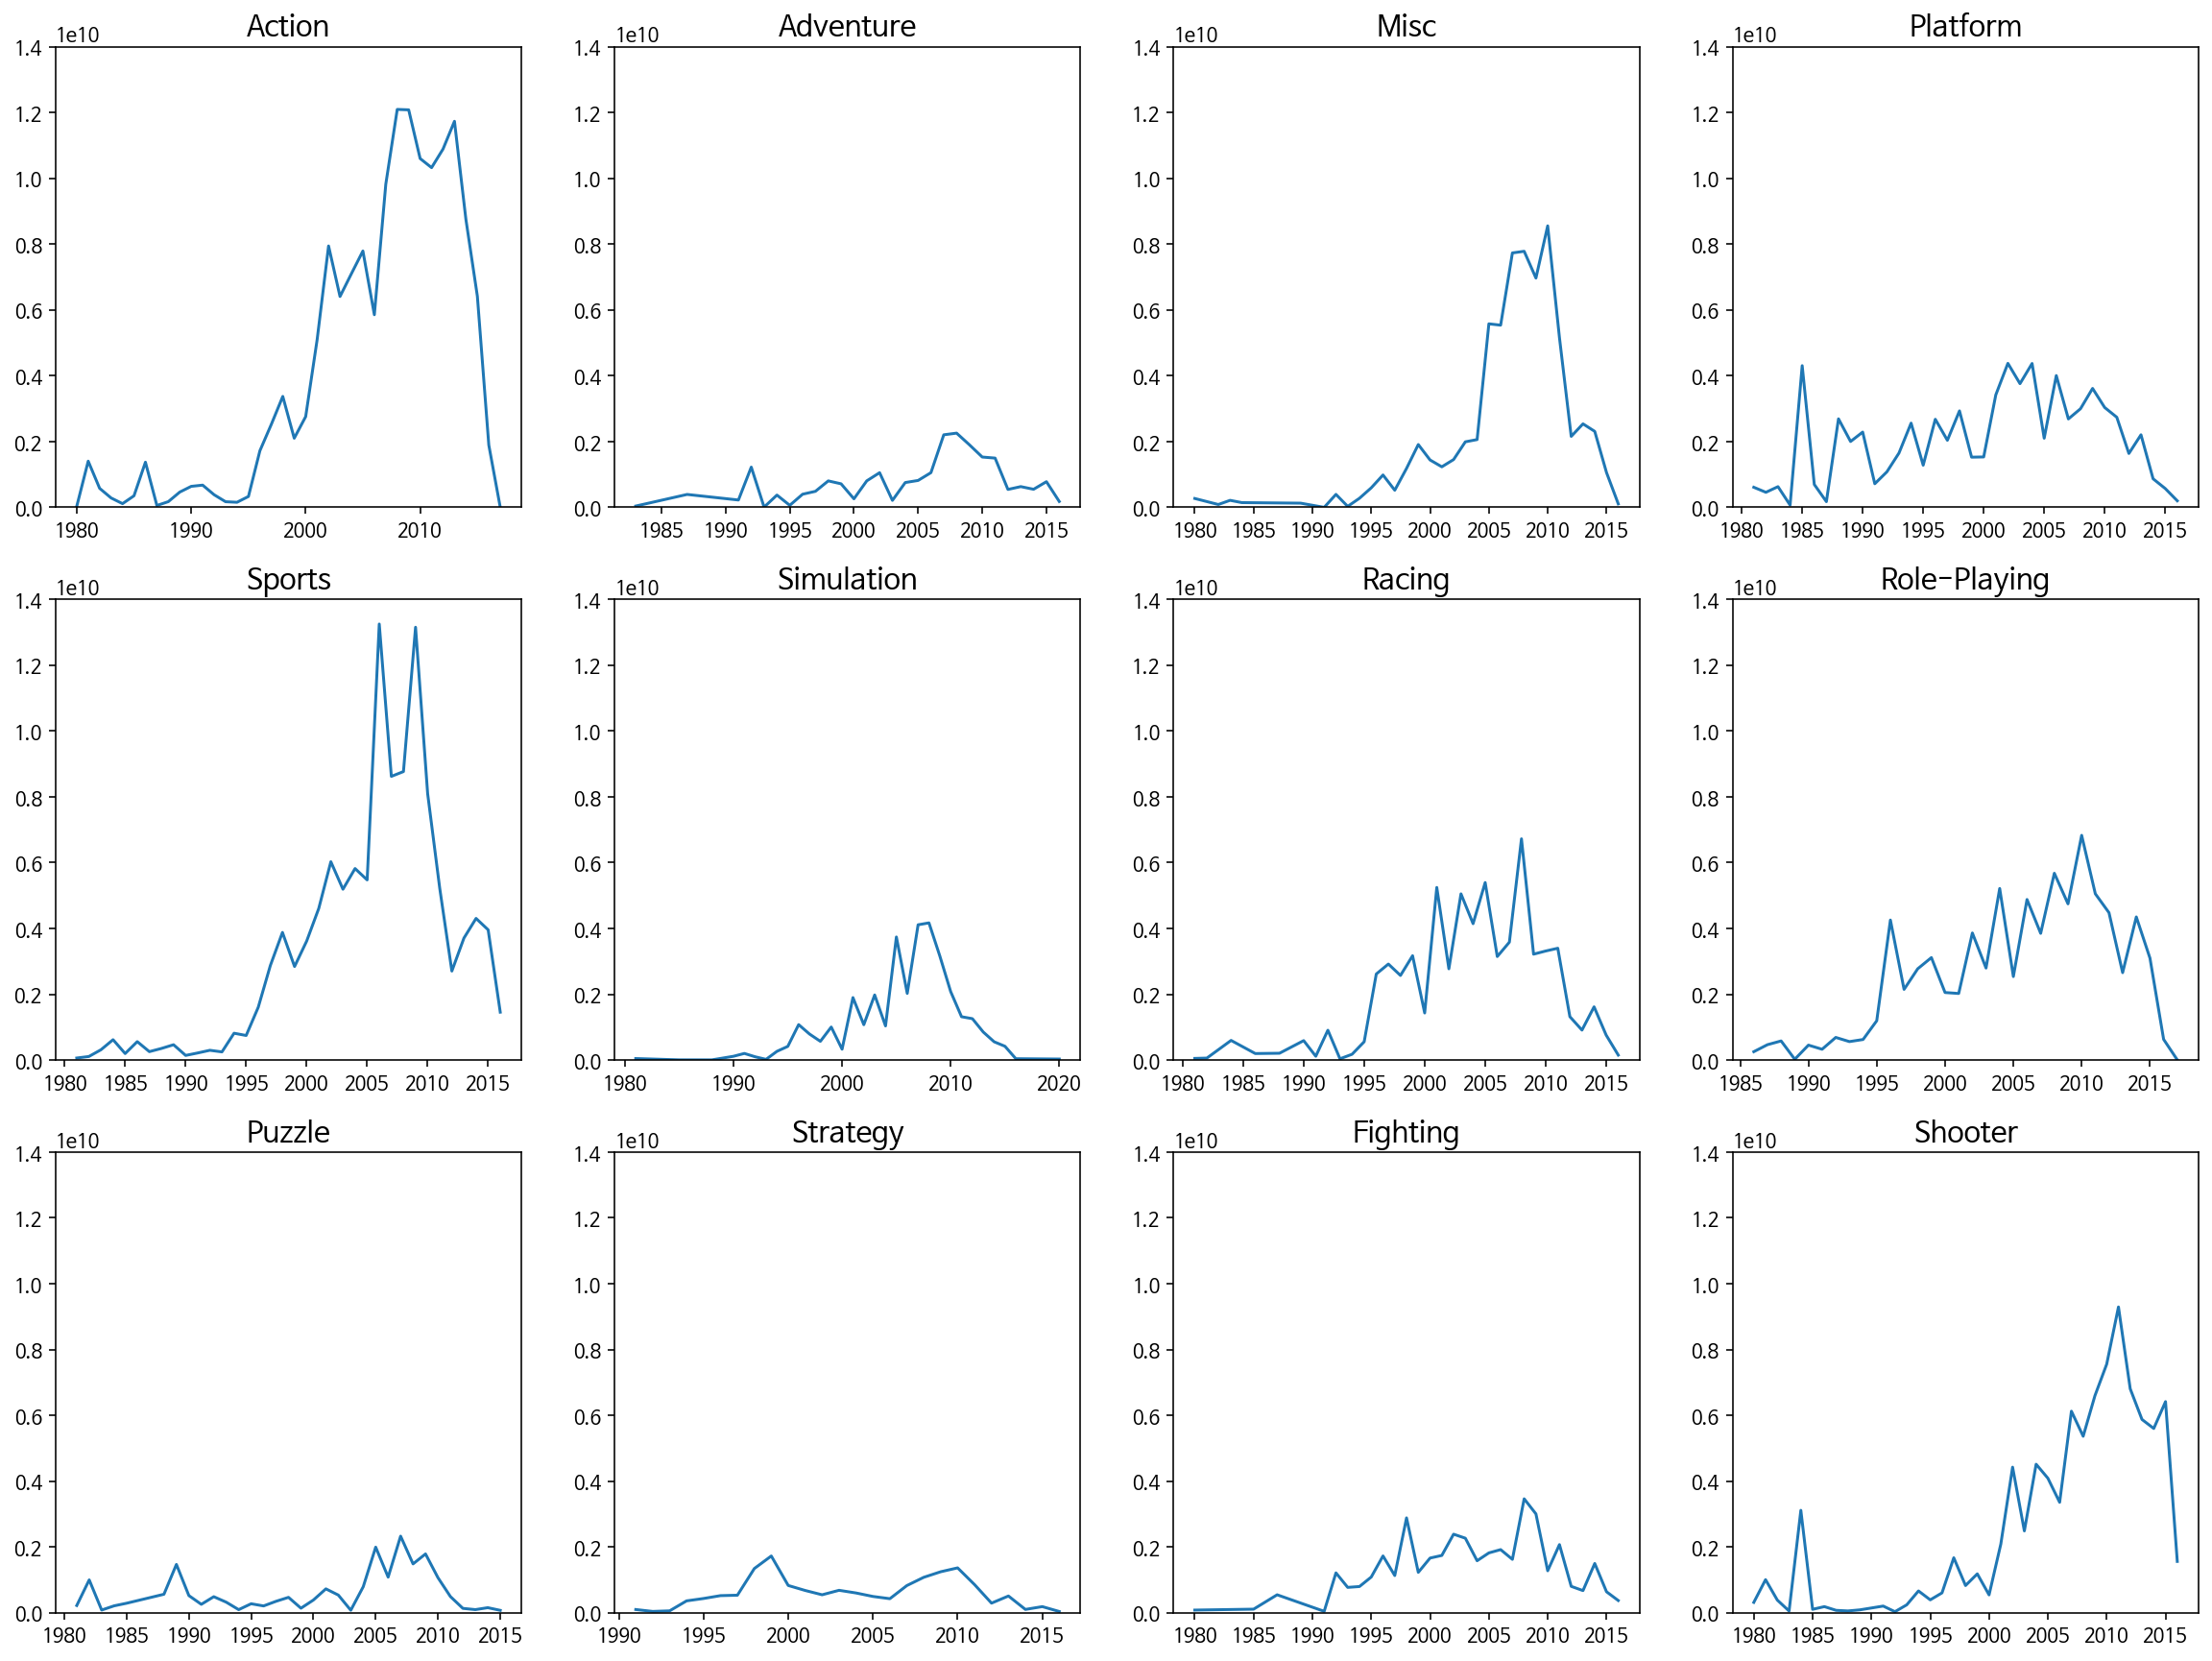

In [ ]:
# 장르별 트랜드는 어떠한가?

plt.figure(figsize=(20,15))
Genre_col = df['Genre'].unique()
for i,genre_name in enumerate(Genre_col):
  plt.subplot(3,4,1+i)
  plt.plot(df[df['Genre'] == Genre_col[i]].groupby('Year')['Global_Sales'].sum())
  plt.title(str(genre_name),fontsize=15)
  plt.ylim(0,14000000000)
plt.show()

마찬가지로 이 그래프에서도   
2000년대 이전에는 Role-Playing이나 Platform장르의 게임이 주로 출시되었으나   
2000년대 이후로는 Action, Sport, Shooting 장르가 급격하게 성장하는 모습을 볼 수 있다.

위 그래프들을 통해 연대별 인기있는 장르가 다르다는 것을 볼 수 있다.  
즉, **연대별로 비디오 게임의 트랜드가 변화한다**는 것을 짐작할 수 있다.  
그렇다면 이 가설이 통계적으로도 유의한지 검정해보자.

In [ ]:
# 연대별로 비디오 게임 장르의 트랜드가 변화하는가?
t = df[df['Year'] <= 1990].groupby('Genre')['Global_Sales'].sum()
t['Strategy'] = 0

xc = pd.DataFrame([t,
                df[(df['Year'] > 1990)&(df['Year'] <= 2000)].groupby('Genre')['Global_Sales'].sum(),
                df[(df['Year'] > 2000)&(df['Year'] <= 2010)].groupby('Genre')['Global_Sales'].sum(),
                df[(df['Year'] > 2010)&(df['Year'] <= 2020)].groupby('Genre')['Global_Sales'].sum()],
                index = ['1980','1990','2000','2010'])

print('\nchi_square statistics:',stats.chi2_contingency(xc)[0])
print('p-value:',stats.chi2_contingency(xc)[1])


chi_square statistics: 120799884004.3224
p-value: 0.0


**귀무가설 (H0): 연대와 장르사이에 관련이 없다.(비디오 게임 장르의 트랜드는 변하지 않는다.)  
대립가설 (H1): 연대와 장르사이에 관련이 있다.(비디오 게임 장르의 트랜드는 변한다.)**  

2 sample 카이제곱 검정을 시행한 결과 p-value값이 0이 나왔다.  
비디오 게임장르에서 트랜드가 없다는 귀무가설을 기각한다.  
즉, **비디오게임 시장에서 게임장르의 트랜드는 계속해서 변화**하는 것으로 판단할 수 있다.

### 3. 출고량이 많은 게임은 어떤 특징들이 있는가?

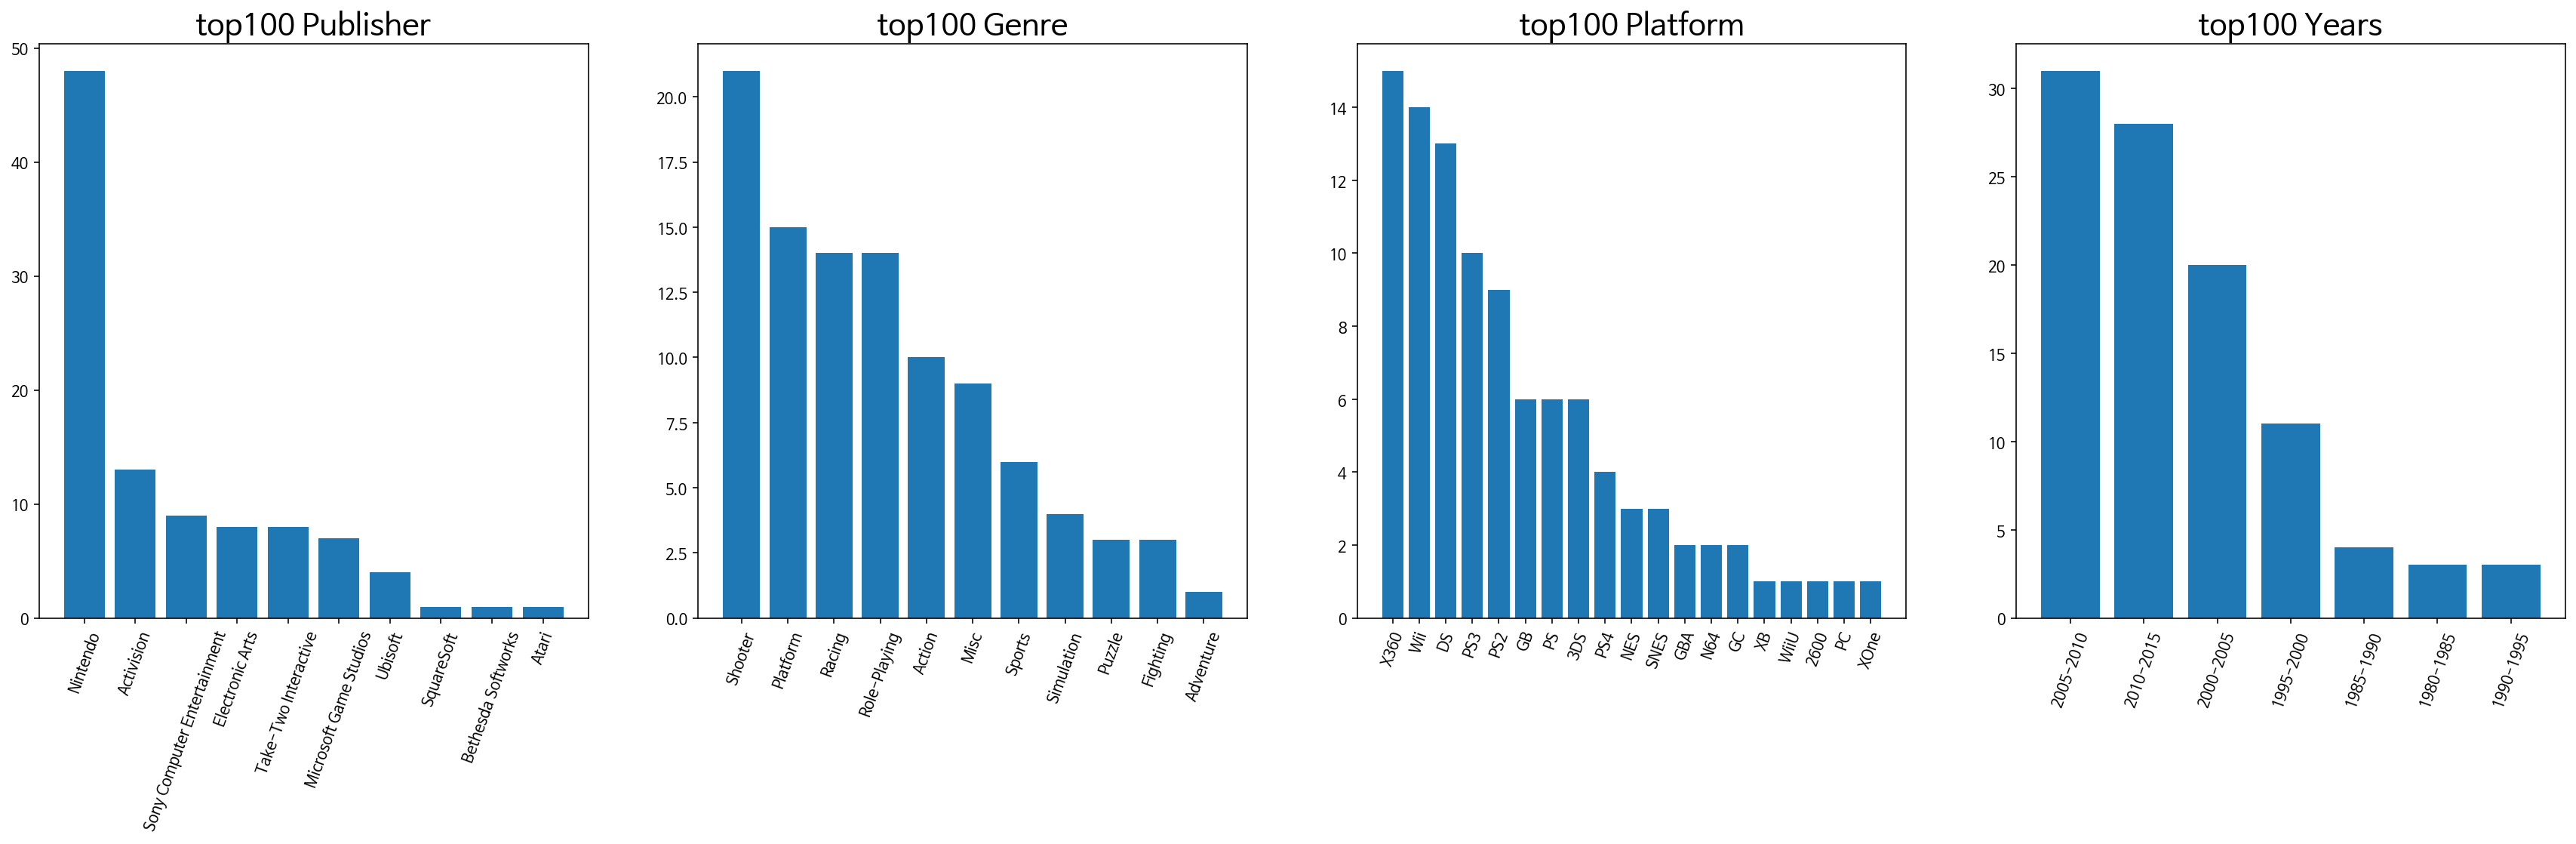

In [ ]:
# 출고량 top100의 장르, 플랫폼, 연대,출판회사
top100 = df.nlargest(100,columns='Global_Sales')

fig, ax = plt.subplots(1, 4, figsize = (30,7))
ax[0].bar(top100['Publisher'].value_counts().index,top100['Publisher'].value_counts())
ax[0].set_title('top100 Publisher',fontsize=20)
ax[1].bar(top100['Genre'].value_counts().index,top100['Genre'].value_counts())
ax[1].set_title('top100 Genre',fontsize=20)
ax[2].bar(top100['Platform'].value_counts().index,top100['Platform'].value_counts())
ax[2].set_title('top100 Platform',fontsize=20)
ax[3].bar(top100['Years'].value_counts().index,top100['Years'].value_counts())
ax[3].set_title('top100 Years',fontsize=20)
for i in range(0,4):
  ax[i].xaxis.set_tick_params(rotation=70)

plt.show()

각각 top3를 기술해보면   
출판회사 : Nintendo, Activision, Sony Computer Entertainment  
장르 : Shooting, Platform, Role-Playing   
플렛폼 : X360, Wii, DS  
연대 : 2005-2010, 2010-2015, 2000-2005  
이렇게 높은 출고량을 보여주고 있다.


###4. 닌텐도에서 새롭게 게임 출시를 한다면 어떨까?


위의 그래프를 보면 특별히 **nintendo**에서 역사적으로 압도적으로 가장 많은 출고량을 기록한것을 볼 수 있다.   
즉, 이미 많은 사람들이 이미 닌텐도 제품을 많이 사용했고, 또 익숙해져 있다고 볼 수 있다.  
따라서 닌텐도 게임회사에서 새로운 게임을 출판하는 것이 성공 가능성이 높다고 생각하였다.  
그렇다면 nintendo에서  **어떤 플렛폼과 지역,장르**의 비디오 게임을 만드는것이 성공할 수 있을까?  
또한
이외에도 최근 닌텐도 게임회사의 **최근 게임출판 현황과 매출성적**을 보고 출판시기를 생각해 볼수도 있을것이다.  
각각의 질문들을 정리해보면

* 닌텐도가 주로 사용하는 플렛폼은?
* 닌텐도의 주력 장르는?
* 닌텐도가 가장 잘 팔리는 지역은?
* 닌텐도의 최근 게임 출판 현황은?
* 닌텐도의 최근 매출 성적은?






In [ ]:
nin_platform = df[df['Publisher'] =='Nintendo']['Platform'].value_counts()
nin_genre = df[df['Publisher'] =='Nintendo']['Genre'].value_counts()
nin_recent = df[df['Publisher'] =='Nintendo']['Years'].value_counts()
nin_region = df[df['Publisher'] =='Nintendo'][['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
nin_recentsales = df[df['Publisher'] =='Nintendo'].groupby('Years')['Global_Sales'].sum()

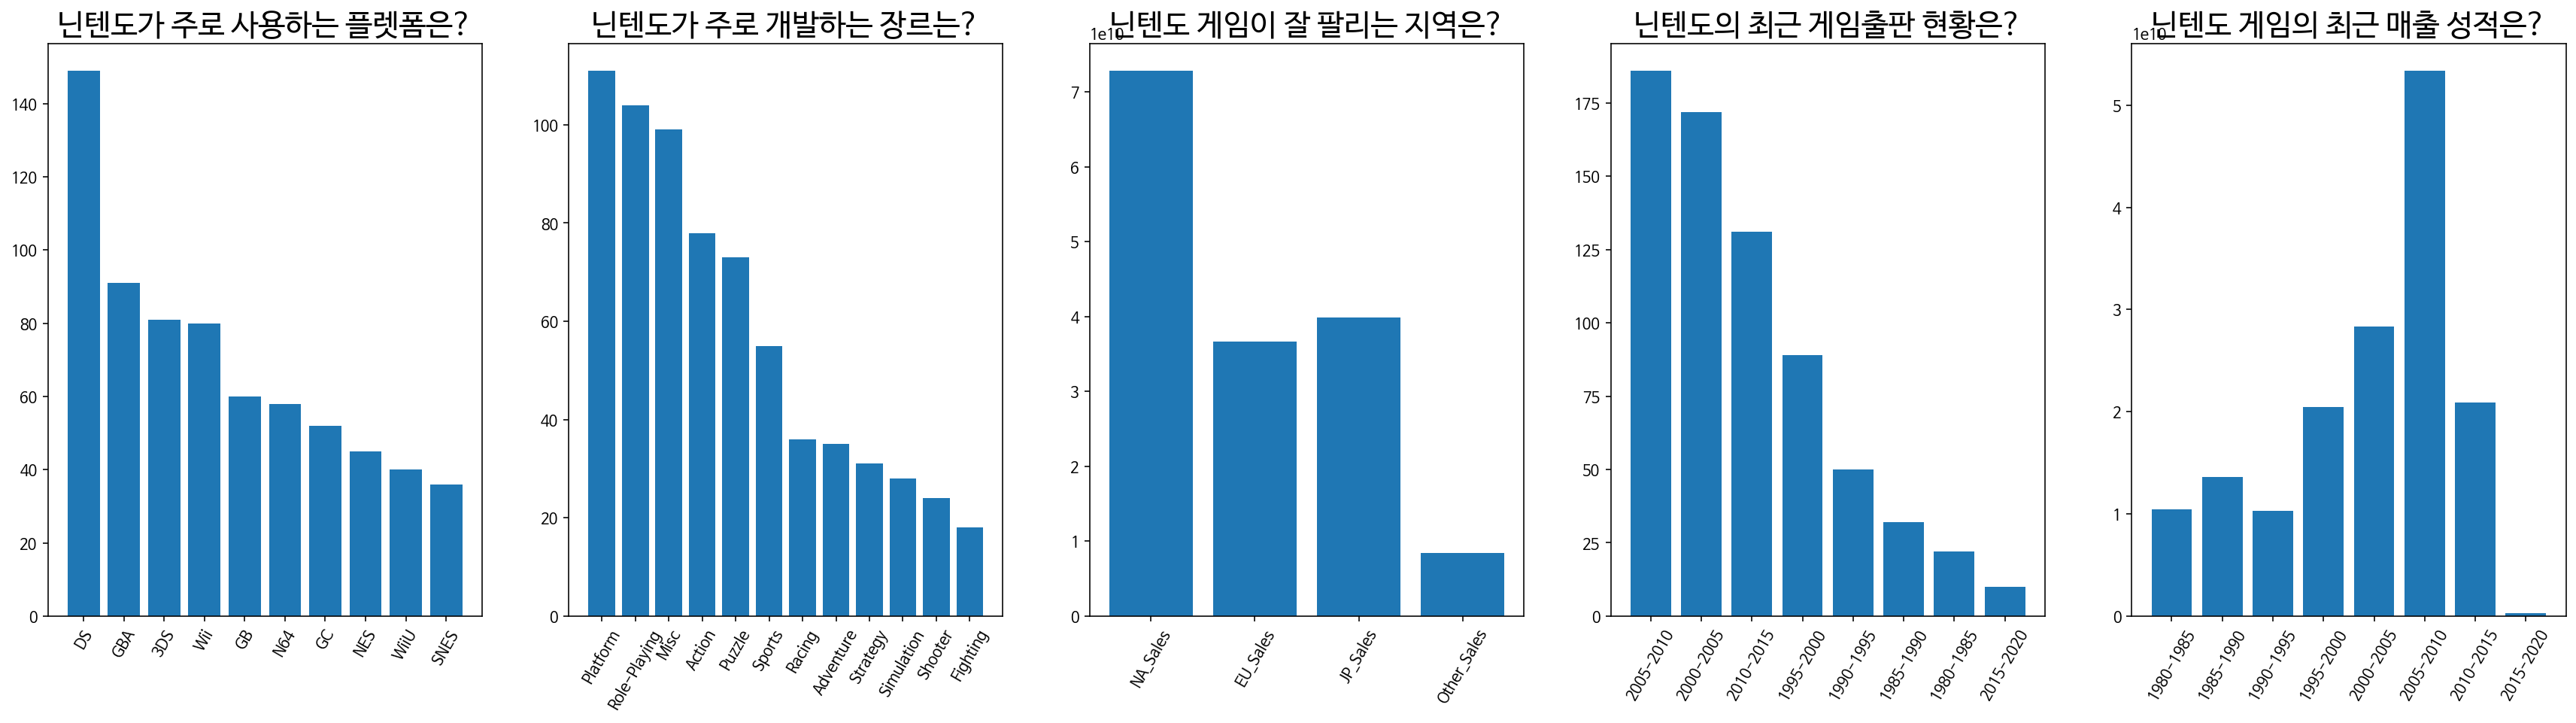

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (30,7))
ax[0].bar(nin_platform.index,nin_platform)
ax[0].set_title('닌텐도가 주로 사용하는 플렛폼은?',fontsize=20)
ax[1].bar(nin_genre.index,nin_genre)
ax[1].set_title('닌텐도가 주로 개발하는 장르는?',fontsize=20)
ax[3].bar(nin_recent.index,nin_recent)
ax[3].set_title('닌텐도의 최근 게임출판 현황은?',fontsize=20)
ax[2].bar(nin_region.index,nin_region)
ax[2].set_title('닌텐도 게임이 잘 팔리는 지역은?',fontsize=20)
ax[4].bar(nin_recentsales.index,nin_recentsales)
ax[4].set_title('닌텐도 게임의 최근 매출 성적은?',fontsize=20)
for i in range(0,5):
  ax[i].xaxis.set_tick_params(rotation=60)

plt.show()

2 sample 카이제곱 검정을 통해서 게임회사와 플렛폼,장르,연도별 출판현황과의 관계성 여부를 검정해보자.  
귀무가설을 기각한다면(관계성이 없다라는 가설을 기각한다면) 그래프에 보인 특징들이 통계적으로 의미있다고 생각할 수 있다.

In [ ]:
# 게임회사와 플렛폼의 연관성
cross_chi2 = pd.crosstab(top100['Publisher'],top100['Platform'])

print('''귀무가설(H0): 게임회사와 플렛폼은 상관관계가 없다.
대립가설(H1): 게임회사와 플렛폼은 상관관계가 있다.''')
print('\np-value:',stats.chi2_contingency(cross_chi2)[1])
print('''\np-value가 0보다 작으므로 귀무가설을 기각한다.
즉, 게임회사와 플렛폼은 상관관계가 있다고 판단할 수 있다

따라서 DS를 통해서 게임을 출시해야 한다''')

귀무가설(H0): 게임회사와 플렛폼은 상관관계가 없다.
대립가설(H1): 게임회사와 플렛폼은 상관관계가 있다.

p-value: 6.491213552978615e-18

p-value가 0보다 작으므로 귀무가설을 기각한다.
즉, 게임회사와 플렛폼은 상관관계가 있다고 판단할 수 있다

따라서 DS를 통해서 게임을 출시해야 한다


In [ ]:
# 게임회사와 장르의 연관성
cross_chi2 = pd.crosstab(top100['Publisher'],top100['Genre'])

print('''귀무가설(H0): 게임회사와 장르는 상관관계가 없다.
대립가설(H1): 게임회사와 장르는 상관관계가 있다.''')
print('\np-value:',stats.chi2_contingency(cross_chi2)[1])
print('''\np-value가 0보다 작으므로 귀무가설을 기각한다.
즉, 게임회사와 장르는 상관관계가 있다고 판단할 수 있다

따라서 Platform 혹은 Role-Playing 장르의 게임을 출시한다.''')

귀무가설(H0): 게임회사와 장르는 상관관계가 없다.
대립가설(H1): 게임회사와 장르는 상관관계가 있다.

p-value: 4.4667819571640334e-20

p-value가 0보다 작으므로 귀무가설을 기각한다.
즉, 게임회사와 장르는 상관관계가 있다고 판단할 수 있다

따라서 Platform 혹은 Role-Playing 장르의 게임을 출시한다.


In [ ]:
# 게임회사와 시대에 따른 출고량의 연관성
cross_chi2 = pd.crosstab(top100['Publisher'],top100['Years'])

print('''귀무가설(H0): 게임회사와 시대에 따른 출고량은 상관관계가 없다.
대립가설(H1): 게임회사와 시대에 따른 출고량은 상관관계가 있다.''')
print('\np-value:',stats.chi2_contingency(cross_chi2)[1])
print('''\np-value가 0보다 작으므로 귀무가설을 기각한다.
즉, 게임회사와 시대에 따른 출고량은 상관관계가 있다고 판단할 수 있다

최근 출고량이 급격하게 줄고 있고, 최근 매출 성적도 좋지 않으므로 출시한다면 가능한 빠른 시일내에 출시한다''')

귀무가설(H0): 게임회사와 시대에 따른 출고량은 상관관계가 없다.
대립가설(H1): 게임회사와 시대에 따른 출고량은 상관관계가 있다.

p-value: 0.0003601938493263223

p-value가 0보다 작으므로 귀무가설을 기각한다.
즉, 게임회사와 시대에 따른 출고량은 상관관계가 있다고 판단할 수 있다

최근 출고량이 급격하게 줄고 있고, 최근 매출 성적도 좋지 않으므로 출시한다면 가능한 빠른 시일내에 출시한다


## 5. 결론

*   게임회사(Publisher) : nintendo
*   플렛폼(Platform): DS
*   출시지역: 북미(NA)지역
*   출시시기: 최대한 빨리 
*   장르(Genre): Platform 혹은 Role-Playing 

게임을 출시한다면 ***nintendo***회사를 통하여 ***DS***플렛폼을 이용하여 ***Platform 혹은 Role-Playing*** 장르의 게임을 **북미지역**에 출시하는 것이 좋아보인다.   
단, 최근 비디오게임 시장의 수요가 급격하게 감소하는 추세이므로 **최대한 빨리** 출시하는 것이 좋다.

